In [13]:
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-fa23-project2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
%%bigquery results --project $project_id

SELECT country_name, SUM(new_confirmed) AS total_cases
    FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
    WHERE new_confirmed IS NOT NULL
    GROUP BY country_name

Query is running:   0%|          |

Downloading:   0%|          |

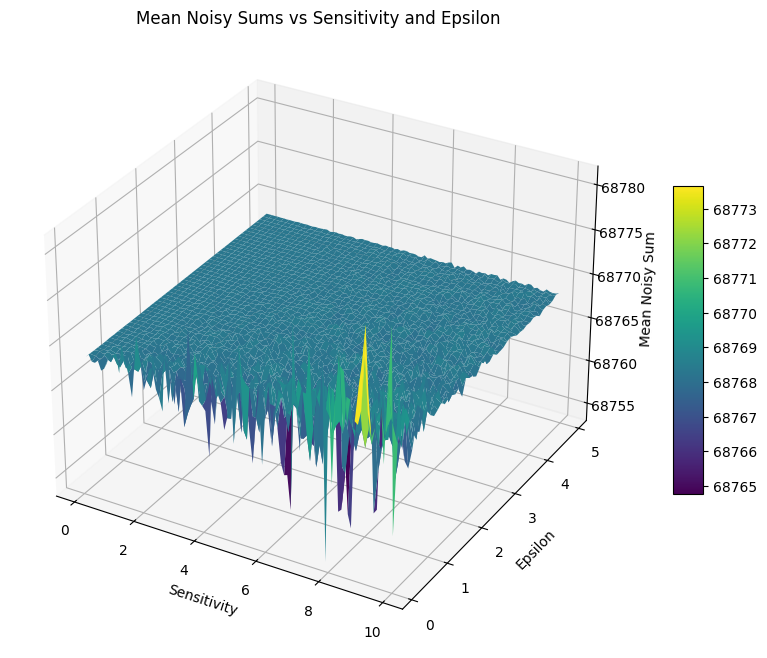

In [17]:
# Add Laplace noise for differential privacy
def add_laplace_noise(value, sensitivity, epsilon):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return value + noise

def bmcs_aggregate(data, map_function, clip_value, sensitivity, epsilon):
    clipped_data = np.clip(map_function(data), -clip_value, clip_value)
    aggregated_sum = np.sum(clipped_data)
    noisy_sum = add_laplace_noise(aggregated_sum, sensitivity, epsilon)
    return noisy_sum

# Example map function for "red-zone" computation
def map_function(data):
    return data

# Parameters
clip_value = 1e5
sensitivity_range = np.arange(0.1, 10, 0.1)
epsilon_range = np.arange(0.1, 5, 0.1)

sensitivity_grid, epsilon_grid = np.meshgrid(sensitivity_range, epsilon_range)

# Function to calculate mean noisy sum for given sensitivity and epsilon
def calculate_noisy_means(results, sensitivity_grid, epsilon_grid):
    noisy_means = np.zeros_like(sensitivity_grid)
    for i in range(sensitivity_grid.shape[0]):
        for j in range(sensitivity_grid.shape[1]):
            sensitivity = sensitivity_grid[i, j]
            epsilon = epsilon_grid[i, j]
            noisy_sums = []
            for _, row in results.iterrows():
                total_cases = row["total_cases"]
                noisy_sum = bmcs_aggregate(
                    data=np.array([total_cases]),
                    map_function=map_function,
                    clip_value=1e5,
                    sensitivity=sensitivity,
                    epsilon=epsilon
                )
                noisy_sums.append(noisy_sum)
            noisy_means[i, j] = np.mean(noisy_sums)
    return noisy_means

# Calculate mean noisy sums
noisy_means = calculate_noisy_means(results, sensitivity_grid, epsilon_grid)

# Visualization as a surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surface = ax.plot_surface(
    sensitivity_grid, epsilon_grid, noisy_means,
    cmap='viridis', edgecolor='none'
)

# Labels and title
ax.set_title("Mean Noisy Sums vs Sensitivity and Epsilon")
ax.set_xlabel("Sensitivity")
ax.set_ylabel("Epsilon")
ax.set_zlabel("Mean Noisy Sum")

# Add color bar
fig.colorbar(surface, shrink=0.5, aspect=10)

plt.show()